In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import cv2
import matplotlib.image as mpimg
from matplotlib import path

(720, 1280, 3)


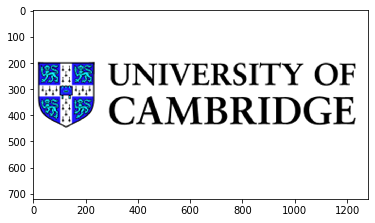

In [2]:
image = cv2.imread('D:/44754/Documents/Data/image.png')
plt.imshow(image)
print(image.shape)
logoy,logox,_ =  image.shape
logo_pts = np.array([[0,0],[logox,0],
                     [logox,logoy],[0,logoy]])

In [3]:
dirdata = 'D:/44754/Documents/robotics/Perception/RoboticsPerceptionWeek2AssignmentCode/data/BarcaReal_pts.mat'
video_pts = sio.loadmat(dirdata)['video_pts']
print(video_pts.shape)
num_ima = video_pts.shape[2]
test_images = np.linspace(1,num_ima,num_ima).astype(int)
num_test = len(test_images)

readdir = 'D:/44754/Documents/robotics/Perception/RoboticsPerceptionWeek2AssignmentCode/images/barcaReal/BarcaReal{:03d}.jpg'

(4, 2, 129)


In [4]:
def calculateInteriorPts(img_size,corners):
    x,y = np.meshgrid(np.linspace(1,img_size[1],img_size[1]),
                     np.linspace(1,img_size[0],img_size[0]))
    X=x.reshape(-1,1); Y=y.reshape(-1,1)
    
    p = path.Path(corners)
    allpts = np.array([X,Y]).squeeze().T
    interior_bol=p.contains_points(allpts)
    return allpts[interior_bol,:]

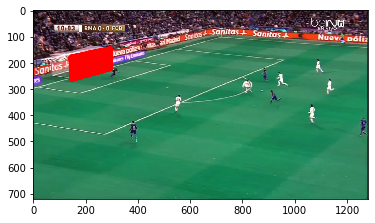

In [5]:
tmp = cv2.imread(readdir.format(test_images[0]))
tmpvidpts = video_pts[:,:,0]
interior_pts = calculateInteriorPts(tmp.shape,tmpvidpts)
plt.imshow(tmp)
plt.plot(interior_pts[:,0],interior_pts[:,1],'r.')

In [6]:
def vectorize(r,rp):
    x1=r[0]; x2=r[1]; x3=1
    x1p=rp[0]; x2p=rp[1]
    ax=[-x1,-x2,-1,0,0,0,x1*x1p,x2*x1p,x1p]
    ay=[0,0,0,-x1,-x2,-x3,x1*x2p,x2*x2p,x2p]
    return ax,ay

In [7]:
def est_homography(video_pts,logo_pts):
    A = []
    for i in range(len(logo_pts)):
        r = tmpvidpts[i,:]; rp = logo_pts[i,:]
        ax,ay = vectorize(r,rp)
        A.append(ax)
        A.append(ay)
    A = np.array(A)
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    H = vh[-1,:].reshape((3,3))
    return H

In [8]:
H = est_homography(tmpvidpts,logo_pts)
H

array([[-3.79571153e-03,  1.48711665e-04,  5.11156805e-01],
       [-8.99478947e-04, -4.17599005e-03,  8.59468283e-01],
       [ 3.50401989e-07,  1.98161589e-08, -5.59264660e-04]])

In [9]:
def warp_pts(video_pts,logo_pts,sample_pts):
    H = est_homography(video_pts,logo_pts)
    warped_pts = []
    for i in range(len(sample_pts)):
        tmp = np.concatenate((sample_pts[i,:],np.array([1])),axis=0)
        result = np.matmul(H,tmp)
        warped_pts.append(result[0:2]/result[2])
    return np.array(warped_pts)

In [10]:
warped_logo_pts=warp_pts(tmpvidpts,logo_pts,interior_pts)

In [11]:
def inverse_warping(imgf,imgi,ptsf,ptsi):
    ptsf = np.floor(ptsf).astype(int)
    ptsi = np.floor(ptsi).astype(int)
    projected_img = imgf
    for i in range(3):
        sif = imgf[:,:,i]
        sii = imgi[:,:,i]
        sif[ptsf[:,1],ptsf[:,0]]=sii[ptsi[:,1],ptsi[:,0]]*.5+sif[ptsf[:,1],ptsf[:,0]]*.5
        projected_img[:,:,i]=sif
    return projected_img

In [12]:
result = inverse_warping(tmp,image,interior_pts,warped_logo_pts)

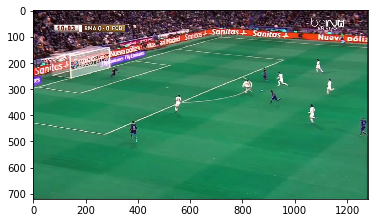

In [13]:
plt.imshow(result)

(-0.5, 1279.5, 719.5, -0.5)

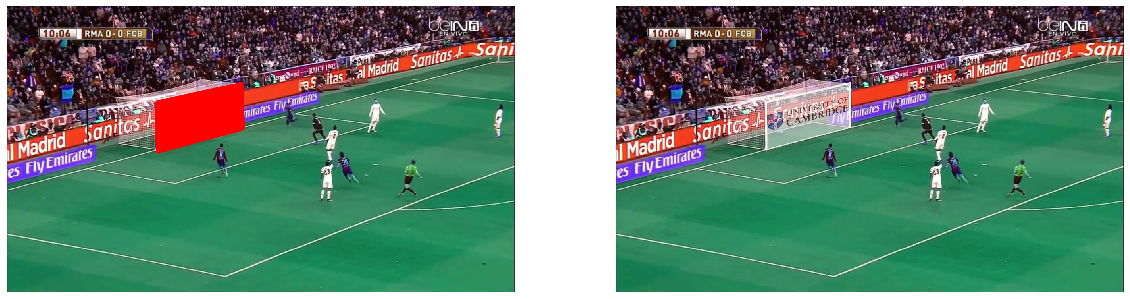

In [14]:
iod = 100
tmp = cv2.imread(readdir.format(test_images[iod]))
tmpvidpts = video_pts[:,:,iod]
interior_pts = calculateInteriorPts(tmp.shape,tmpvidpts)
warped_logo_pts=warp_pts(tmpvidpts,logo_pts,interior_pts)
result = inverse_warping(tmp,image,interior_pts,warped_logo_pts)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(tmp)
plt.plot(interior_pts[:,0],interior_pts[:,1],'r.')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(result)
plt.axis('off')

In [15]:
resultlist = []
for iod in range(129):
    tmp = cv2.imread(readdir.format(test_images[iod]))
    tmpvidpts = video_pts[:,:,iod]
    interior_pts = calculateInteriorPts(tmp.shape,tmpvidpts)
    warped_logo_pts=warp_pts(tmpvidpts,logo_pts,interior_pts)
    result = inverse_warping(tmp,image,interior_pts,warped_logo_pts)
    resultlist.append(result)

In [19]:
resultlist = np.array(resultlist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


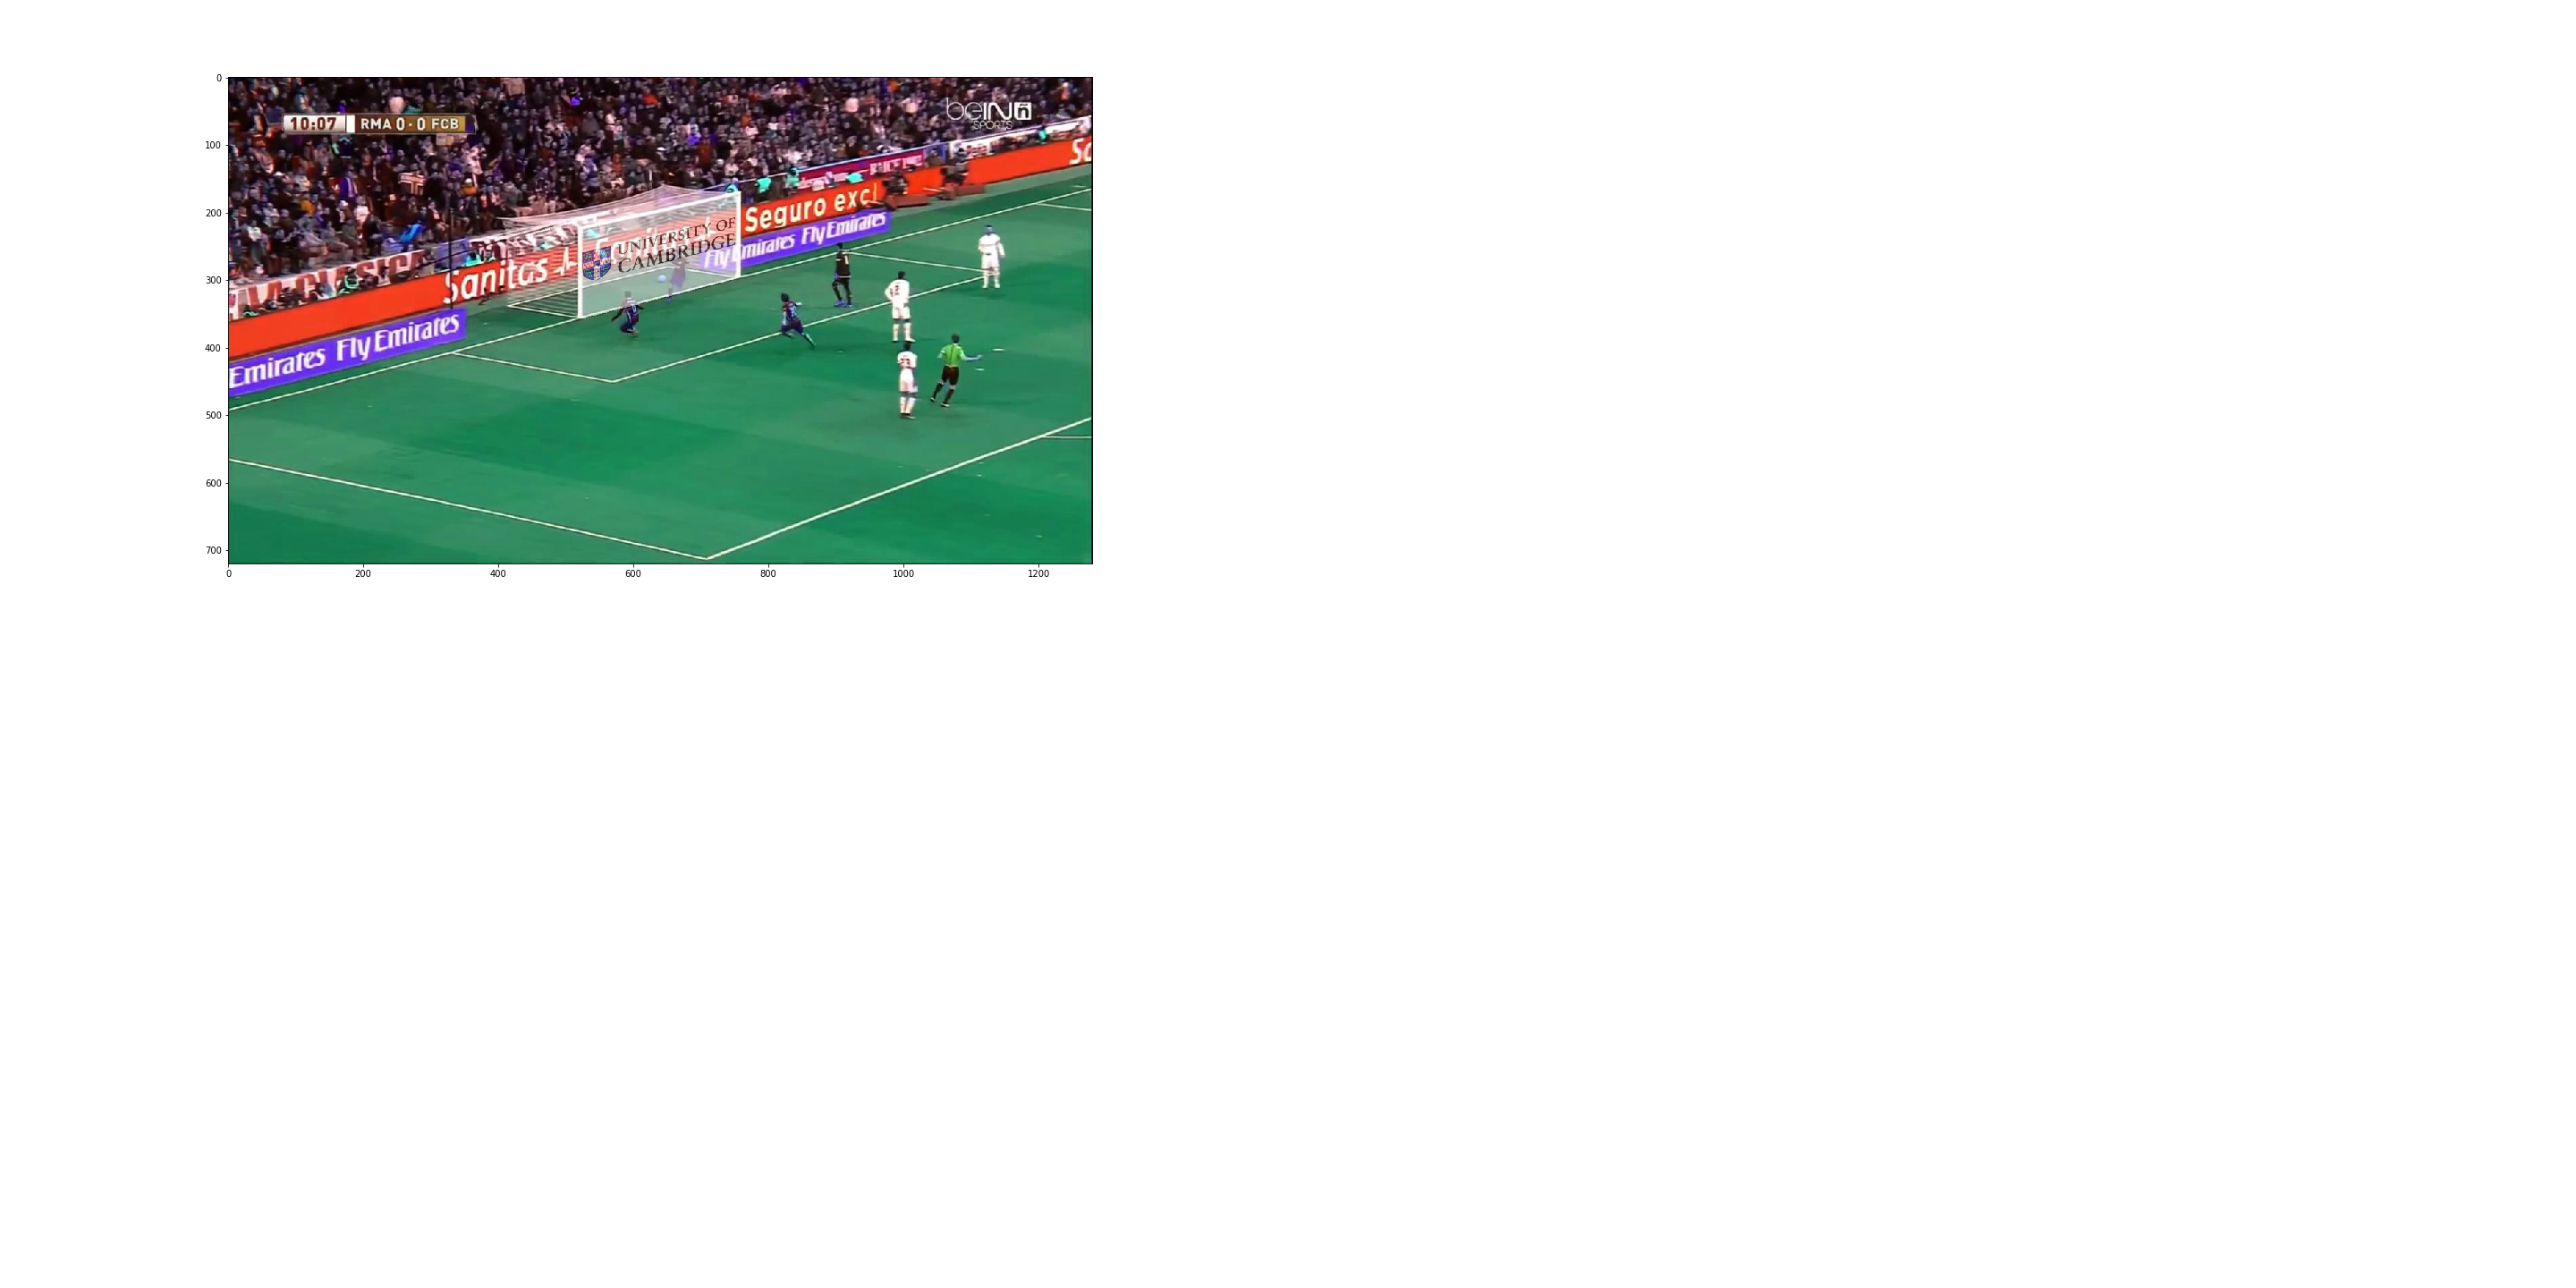

<IPython.core.display.Javascript object>


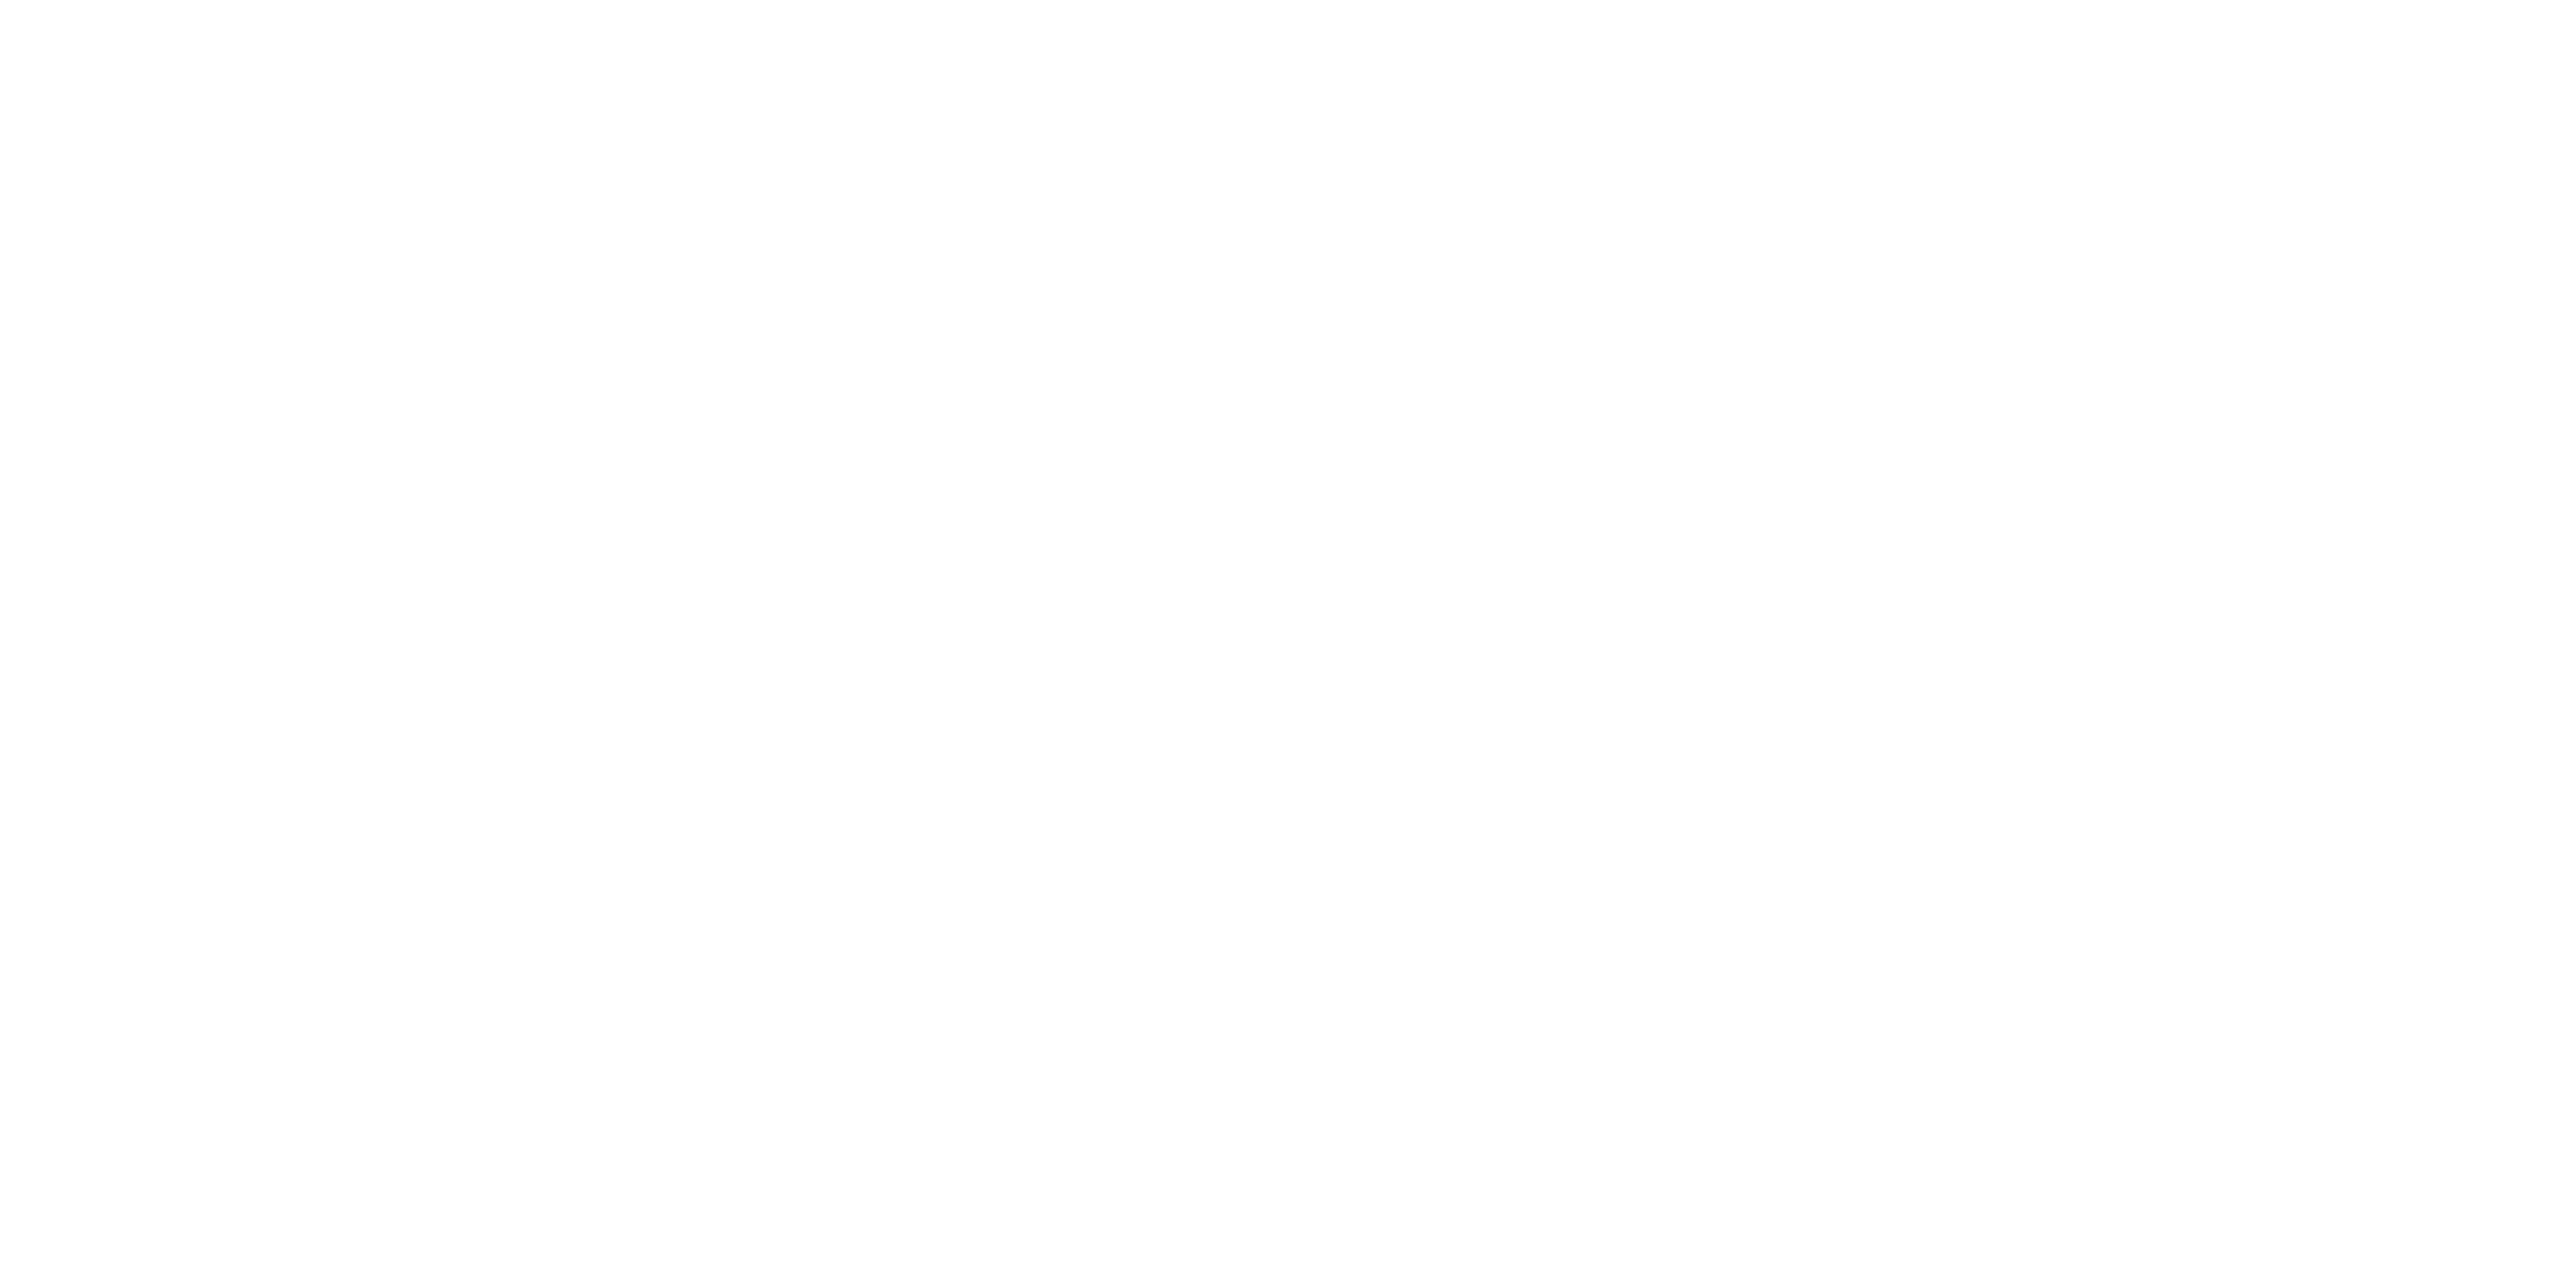

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
fig = plt.figure(figsize=(20,10))
ax = plt.gca()
plt.ion()
fig.show()
fig.canvas.draw()
for i in range(129):
    ax.clear()
    ax.imshow(resultlist[i,:,:,:])
    fig.canvas.draw()